<a href="https://colab.research.google.com/github/soulsharp/Attentive-Segnet/blob/main/Attentive_SegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import math
import random
import seaborn as sns

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Config dictionary** contains the configuration parameters for training and constructing the model

In [54]:
config = {

    "embed_dim":64,
    "patch_size":32,
    "in_channels":3,
    "weight_bce": 0.2,
    "weight_dice": 0.8,
    "epsilon_loss_fn": 1e6,
    "train_batch_size": 32,
    "train_epochs": 50,
    "lr": 1e-4,
    "ckpt_name": 'att_segnet.pth',
    "model_save_path":"/content/saved_models"

}

**CrackDataset** derived from torch.utils.data.Dataset contains logic to load the dataset from certain directories and apply transformations/ augmentations to it, if provided




In [55]:
class CrackDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        """
        Custom Concrete Failure Detection(Crack) dataset

        Args:
            image_dir (str): Path to the directory containing RGB images.
            mask_dir (str): Path to the directory containing mask images.
            transform (callable, optional): A function/transform to apply to both images and masks.
        """
        self.image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.jpg', '.png', '.jpeg'))])
        self.mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith(('.jpg', '.png', '.jpeg'))])

        if len(self.image_paths) != len(self.mask_paths):
            raise ValueError("Number of images and masks must be the same!")

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Loads image and mask
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv.imread(image_path)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)

        if image is None:
            raise ValueError(f"Failed to load image: {image_path}")
        if mask is None:
            raise ValueError(f"Failed to load mask: {mask_path}")

        # Applies transformations
        if self.transform:
            image, mask = self.transform(image, mask)

        # Convert to tensors
        image = torch.as_tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.as_tensor(mask, dtype=torch.float32)

        return image, mask

# Simple preprocessing function
def transform_image_and_mask(image, mask, size=512):
    # Resize image and mask
    image = cv.resize(image, (size, size), interpolation=cv.INTER_NEAREST)
    mask = cv.resize(mask, (size, size), interpolation=cv.INTER_NEAREST)
    mask = mask/255.0
    return image, mask

This function creates the train data loader and the validation data loader from given image directories using the CrackDataset class

In [56]:
def make_train_val_loaders(image_directory, mask_directory):
  # Instantiates dataset
  dataset = CrackDataset(image_dir=image_directory, mask_dir=mask_directory, transform=transform_image_and_mask)

  # Train-validation split
  train_ratio = 0.8
  train_size = int(len(dataset) * train_ratio)
  val_size = len(dataset) - train_size
  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  # Creates DataLoaders
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

  return train_loader, val_loader

**Patch_Embedding**

This class derived from nn.Module forms a core transformation included in the Attentive Segnet model.It takes an image batch of shape **(Batch_size, channels, height, width)** and divides the input images into equal sized patches resulting in a tensor of the shape **(Batch_size, num_patches, embed_dim)**.

Each patch contains encoded information about a section of the image

In [57]:
# Encodes patch representation of an image batch
class Patch_Embedding(nn.Module):
    def __init__(self, embed_dim=64, patch_size=32, in_channels=3):
        super(Patch_Embedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.convolution = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # Expects x to be of shape (batch_size, channels, height, width)
        h, w = x.shape[2], x.shape[3]
        if h % self.patch_size != 0 or w % self.patch_size != 0:
          raise ValueError("Input dimensions must be divisible by the patch size.")
        # Applies convolution to create patches
        patches = self.convolution(x)

        return patches

In [58]:
# returns a tensor after applying maxpool2d
# also returns the indices used up in the max pool
class MaxPoolWithIndices(nn.Module):
    def __init__(self, kernel_size, stride):
        super(MaxPoolWithIndices, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.maxpool = nn.MaxPool2d(kernel_size=self.kernel_size, stride=self.stride, return_indices=True)

    def forward(self, x):
        output, indices = self.maxpool(x)
        return output, indices

In [59]:
# basic convblock with conv2d-->batchnorm-->relu-->maxpool(optional)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, maxpool_flag=True):
        super(ConvBlock, self).__init__()
        self.maxpool_flag = maxpool_flag
        self.operation_seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        if self.maxpool_flag:
            self.maxpool = MaxPoolWithIndices(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.operation_seq(x)

        if self.maxpool_flag:
            pooled, indices = self.maxpool(x)
            return pooled, indices
        else:
            return x, None

In [60]:
class Downsample(nn.Module):
    def __init__(self):
        super(Downsample, self).__init__()

        # Initializes the conv blocks
        self.conv_blocks = nn.ModuleList([
            ConvBlock(3, 8, 3, 1, 1),
            ConvBlock(8, 16, 3, 1, 1),
            ConvBlock(16, 32, 3, 1, 1),
            ConvBlock(32, 64, 3, 4, 1, False)  # block4 (no maxpool)
        ])

    def forward(self, input_tensor):
        max_indices = {}
        bottleneck_input = None

        # Ensures that input dimensions are divisible by 4
        assert input_tensor.shape[-2] % 4 == 0 and input_tensor.shape[-1] % 4 == 0, \
            "Input dimensions must be divisible by 4 for this downsampling pipeline."

        # Goes through all blocks in conv blocks sequentially
        for idx, conv_block in enumerate(self.conv_blocks):
            input_tensor, indices = conv_block(input_tensor)

            # Saves max indices for each block
            block_name = f"block{idx + 1}"

            # The last block ie block4 gives the output to be used as bottleneck
            if block_name == "block4":
                bottleneck_input = input_tensor
            else:
                max_indices[block_name] = indices

        return max_indices, bottleneck_input

In [61]:
# Attention weights to scale the patch embed representation
class AttentionWeights(nn.Module):
    def __init__(self, output_dim):
        super(AttentionWeights, self).__init__()
        self.alphas = nn.Parameter(torch.randn(output_dim))
        self.layer_norm = nn.LayerNorm([256, 64])

    def forward(self, patch_emb_tensor):

        # adding a dimension ie making alphas (256, 1) for proper broadcasting
        scaled_input = self.alphas.unsqueeze(1) * patch_emb_tensor

        # Normalizes input for stability
        normalized_scaled_input = self.layer_norm(scaled_input)

        return normalized_scaled_input


In [62]:
# Takes in the bottleneck tensor and adds patch embeddings to it
def add_bottleneck_and_patch_embeddings(bottleneck, patch_embedding):

  num_batches, num_channels, h, w = bottleneck.shape
  patch_embedding = patch_embedding.permute(0, 2, 1)
  patch_embedding = patch_embedding.view(num_batches, num_channels, h, w)

  return bottleneck + patch_embedding

In [63]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(UpBlock, self).__init__()
        self.operation_sequence = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        output = self.operation_sequence(x)
        return output

In [64]:
class Unpool2d(nn.Module):
  def __init__(self, k_sz, stride):
    super(Unpool2d, self).__init__()
    self.unpool2d = nn.MaxUnpool2d(k_sz, stride)

  def forward(self, pooled, indices):
    return self.unpool2d(pooled, indices)

In [65]:
class Upsample(nn.Module):
    def __init__(self):
        super(Upsample, self).__init__()

        # Defines the sequence of UpBlocks and Unpool2d layers
        self.up_blocks = nn.ModuleList([
            UpBlock(64, 32, kernel_size=4, stride=4, padding=0),
            Unpool2d(2, 2),
            UpBlock(32, 16, kernel_size=3, stride=1, padding=1),
            Unpool2d(2, 2),
            UpBlock(16, 8, kernel_size=3, stride=1, padding=1),
            Unpool2d(2, 2),
            UpBlock(8, 1, kernel_size=3, stride=1, padding=1),
        ])

    def forward(self, input_tensor, max_indices):
        count = 0
        for idx, layer in enumerate(self.up_blocks):

            # Upblock layer
            if idx % 2 == 0:
                input_tensor = layer(input_tensor)

            # Unpool layer
            else:
                max_index_key = "block" + str(3 - count)
                input_tensor = layer(input_tensor, max_indices[max_index_key])
                count += 1
        return input_tensor

In [66]:
class weightedBCEDiceLoss(nn.Module):
  def __init__(self, weight_BCE, weight_Dice, epsilon):
    super(weightedBCEDiceLoss, self).__init__()
    self.alpha = weight_BCE
    self.beta = weight_Dice
    self.eps = epsilon
    assert math.isclose(self.alpha + self.beta, 1.0, rel_tol=1e-6), "Weights of BCE and Dice Loss must sum to 1"

  def forward(self, preds, targets):
    preds = preds.view(-1)
    targets = targets.view(-1)
    print(f"Shape of prds is {preds.shape}, shape of targets is {targets.shape}")

    bce_criterion = nn.BCELoss()
    bce_loss = bce_criterion(preds, targets)

    intersection = torch.sum(preds * targets)
    union = torch.sum(preds) + torch.sum(targets)
    dice_coeff = (2 * intersection + self.eps) / (union + self.eps)
    dice_loss = 1 - dice_coeff

    total_loss = self.alpha * bce_loss + self.beta * dice_loss

    return total_loss


In [67]:
class AttentiveSegnet(nn.Module):
  def __init__(self, config):
    super(AttentiveSegnet, self).__init__()
    self.patch_embedding = Patch_Embedding(config["embed_dim"], config["patch_size"], config["in_channels"])
    self.downsample_block = Downsample()
    self.upsample_block = Upsample()
    self.attention_weights = AttentionWeights(256)
    self.embed_dim = config['embed_dim']
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # Computes patch encodings for the input tensor x and scales the representations
    patched_encodings = self.patch_embedding(x)
    patched_encodings = patched_encodings.view(patched_encodings.size(0), -1, self.embed_dim)
    attention_dim = patched_encodings.size(1)

    # # Dynamically initialize attention weights if not already initialized
    # if self.attention_weights is None:
    #   self.attention_weights = AttentionWeights(attention_dim)
    #   self.add_module("Attention_weights", self.attention_weights)

    # self.attention_weights = self.attention_weights.to(patched_encodings.device)

    scaled_embeddings = self.attention_weights(patched_encodings)

    # Downsample, combine embeddings and upscale
    max_indices, bottleneck_input = self.downsample_block(x)

    print(f"Max val of bneck input is {torch.max(bottleneck_input)}, Min val of bneck input is {torch.min(bottleneck_input)}")

    bottleneck_plus_emb = add_bottleneck_and_patch_embeddings(bottleneck_input, scaled_embeddings)

    print(f"Max val of bottleneck_plus_emb {torch.max(bottleneck_plus_emb)}, Min val of bneckplusemb is {torch.min(bottleneck_plus_emb)}")
    output_mask = self.upsample_block(bottleneck_plus_emb, max_indices)

    # Debugging
    print(f"Max val before sigmoid is {torch.max(output_mask)}, Min val before sigmoid is {torch.min(output_mask)}")
    output_mask = self.sigmoid(output_mask)

    return output_mask


In [68]:
def train_for_one_epoch(epoch_idx, model, train_loader, optimizer, config):

    r"""
    Method to run the training for one epoch.
    :param epoch_idx: iteration number of current epoch
    :param model: Attentive SegNet model
    :param train_loader: Dataloader for the training set
    :param optimizer: optimizer to be used
    :param config: config dictionary that contains model information
    :return: loss value for the epoch
    """

    losses = []
    criterion = weightedBCEDiceLoss(config["weight_bce"], config["weight_dice"], config["epsilon_loss_fn"])

    # Iterates through the dataloader in form of batches
    for batch in tqdm(train_loader):
        im, mask = batch
        im = im.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        model_output = model(im)
        loss = criterion(model_output, mask)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    # Prints epoch and loss info
    print('Finished epoch: {} | Number Loss : {:.4f}'.
          format(epoch_idx + 1,
                 np.mean(losses)))
    return np.mean(losses)

def train(train_loader, config):
    model = AttentiveSegnet(config).to(device)
    num_epochs = config['train_epochs']
    optimizer = Adam(model.parameters(), lr=config['lr'])
    scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2, verbose=True)

    # Creates output directories
    if not os.path.exists(config['model_save_path']):
        os.mkdir(config['model_save_path'])

    # Loads checkpoint if found
    if os.path.exists(os.path.join(config['model_save_path'], config['ckpt_name'])):
        print('Loading checkpoint')
        model.load_state_dict(torch.load(os.path.join(config['model_save_path'],
                                    config['ckpt_name']), map_location=device))
    best_loss = np.inf

    for epoch_idx in range(num_epochs):
        mean_loss = train_for_one_epoch(epoch_idx, model, train_loader, optimizer, config)
        scheduler.step(mean_loss)

        # Updates checkpoint if better model params found
        if mean_loss < best_loss:
            print('Improved Loss to {:.4f} .... Saving Model'.format(mean_loss))
            torch.save(model.state_dict(), os.path.join(config['model_save_path'],
                                            config['ckpt_name']))
            best_loss = mean_loss
        else:
            print('No Loss Improvement')

In [78]:
def get_segmentation_accuracy(preds, targets):
  preds = preds.view(-1)
  targets = targets.view(-1)

  matches = (preds == targets).sum().item()
  accuracy = matches / preds.size(0)
  return accuracy

def post_process(preds):
  result = torch.where(preds>0.515, 255.0 , 0.0)
  return result

def visualize_preds(preds, masks):
   fig, axes = plt.subplots(4, 2, figsize=(10, 20))

   for i in range(4):
      axes[i, 0].imshow(masks[i].squeeze(1).cpu().detach().numpy(), cmap='gray')
      axes[i, 0].set_title(f"Ground Truth {i+1}")
      axes[i, 0].axis('off')

      axes[i, 1].imshow(preds[i].squeeze().cpu().detach().numpy(), cmap='gray')
      axes[i, 1].set_title(f"Prediction {i+1}")
      axes[i, 1].axis('off')

   plt.tight_layout()
   plt.show()


def inference(val_loader, config):
   model = AttentiveSegnet(config).to(device)
   model.eval()

   # Loads checkpoint if found
   if os.path.exists(os.path.join(config['model_save_path'], config['ckpt_name'])):
        print('Loading checkpoint')
        model.load_state_dict(torch.load(os.path.join(config['model_save_path'],
                                     config['ckpt_name']), map_location=device))
   else:
        print('No checkpoint found at {}'.format(os.path.join(config['model_save_path'],
                                        config['ckpt_name'])))

   for idx, batch in enumerate(tqdm(val_loader)):
        im, mask = batch
        im = im.to(device)
        mask = mask.to(device)
        preds = model(im)
        preds = preds.to(device)

        preds = post_process(preds)

        # Randomly picks any 4 images of the 1st batch for viz
        if idx == 0:
            random_indices = random.sample(range(im.size(0)), 4)
            selected_images = im[random_indices]
            selected_preds = preds[random_indices]
            selected_masks = mask[random_indices]
            visualize_preds(selected_preds, selected_masks)

            print(torch.max(selected_preds), torch.min(selected_preds))

            sns.histplot(selected_preds.cpu().detach().numpy().flatten(), bins=255)
            plt.title("Distribution of Selected Predictions")
            plt.xlabel("Prediction Values")
            plt.ylabel("Frequency")
            plt.show()



        accuracy = get_segmentation_accuracy(preds, mask)
        print(f"Accuracy in batch {idx} during validation is: {accuracy:.4f}")

In [70]:
image_directory = "/content/images"
mask_directory = "/content/masks"
train_loader, val_loader = make_train_val_loaders(image_directory, mask_directory)

In [71]:
model = AttentiveSegnet(config).to(device)
print(type(model.parameters()))

<class 'generator'>


In [72]:
for param in model.parameters():
    print(param.device)

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


In [73]:
for name, param in model.named_parameters():
    print(name, param.size(), param.device)

patch_embedding.convolution.weight torch.Size([64, 3, 32, 32]) cuda:0
patch_embedding.convolution.bias torch.Size([64]) cuda:0
downsample_block.conv_blocks.0.operation_seq.0.weight torch.Size([8, 3, 3, 3]) cuda:0
downsample_block.conv_blocks.0.operation_seq.0.bias torch.Size([8]) cuda:0
downsample_block.conv_blocks.0.operation_seq.1.weight torch.Size([8]) cuda:0
downsample_block.conv_blocks.0.operation_seq.1.bias torch.Size([8]) cuda:0
downsample_block.conv_blocks.1.operation_seq.0.weight torch.Size([16, 8, 3, 3]) cuda:0
downsample_block.conv_blocks.1.operation_seq.0.bias torch.Size([16]) cuda:0
downsample_block.conv_blocks.1.operation_seq.1.weight torch.Size([16]) cuda:0
downsample_block.conv_blocks.1.operation_seq.1.bias torch.Size([16]) cuda:0
downsample_block.conv_blocks.2.operation_seq.0.weight torch.Size([32, 16, 3, 3]) cuda:0
downsample_block.conv_blocks.2.operation_seq.0.bias torch.Size([32]) cuda:0
downsample_block.conv_blocks.2.operation_seq.1.weight torch.Size([32]) cuda:0
d

In [74]:
train(train_loader, config)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-68-6bec21f05579>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of t

Loading checkpoint


 33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

Max val of bneck input is 7.559404373168945, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.754802703857422, Min val of bneckplusemb is -8.342988967895508
Max val before sigmoid is 77.56551361083984, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.32it/s]

Max val of bneck input is 6.766170978546143, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.78575325012207, Min val of bneckplusemb is -8.740220069885254
Max val before sigmoid is 91.60211944580078, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


Max val of bneck input is 6.244451522827148, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 18.66618537902832, Min val of bneckplusemb is -8.939910888671875
Max val before sigmoid is 78.60668182373047, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 1 | Number Loss : 0.7713
Improved Loss to 0.7713 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.01it/s]

Max val of bneck input is 7.759706974029541, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.87527084350586, Min val of bneckplusemb is -7.977551460266113
Max val before sigmoid is 96.82029724121094, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.83it/s]

Max val of bneck input is 7.614490509033203, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.748931884765625, Min val of bneckplusemb is -8.93425464630127
Max val before sigmoid is 86.03348541259766, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Max val of bneck input is 6.449636936187744, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.999130249023438, Min val of bneckplusemb is -8.760283470153809
Max val before sigmoid is 89.81394958496094, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 2 | Number Loss : 0.7713
Improved Loss to 0.7713 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.34it/s]

Max val of bneck input is 6.59019660949707, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.947202682495117, Min val of bneckplusemb is -8.923640251159668
Max val before sigmoid is 87.5542984008789, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.26it/s]

Max val of bneck input is 6.421115398406982, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 18.25543975830078, Min val of bneckplusemb is -7.717930793762207
Max val before sigmoid is 80.88399505615234, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Max val of bneck input is 8.206999778747559, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.099925994873047, Min val of bneckplusemb is -8.395770072937012
Max val before sigmoid is 99.91527557373047, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 3 | Number Loss : 0.7710
Improved Loss to 0.7710 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.37it/s]

Max val of bneck input is 6.813803195953369, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 18.78870964050293, Min val of bneckplusemb is -8.915562629699707
Max val before sigmoid is 74.0175552368164, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.28it/s]

Max val of bneck input is 7.28712272644043, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.771324157714844, Min val of bneckplusemb is -8.459546089172363
Max val before sigmoid is 96.65693664550781, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Max val of bneck input is 7.502540111541748, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.022829055786133, Min val of bneckplusemb is -8.755354881286621
Max val before sigmoid is 84.2745132446289, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 4 | Number Loss : 0.7710
Improved Loss to 0.7710 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.36it/s]

Max val of bneck input is 7.6039652824401855, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.923267364501953, Min val of bneckplusemb is -8.759724617004395
Max val before sigmoid is 75.0315170288086, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.28it/s]

Max val of bneck input is 7.16860818862915, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.18575668334961, Min val of bneckplusemb is -8.929778099060059
Max val before sigmoid is 96.7462387084961, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Max val of bneck input is 6.931324005126953, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 18.174591064453125, Min val of bneckplusemb is -8.39484691619873
Max val before sigmoid is 101.05038452148438, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 5 | Number Loss : 0.7708
Improved Loss to 0.7708 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

Max val of bneck input is 8.173918724060059, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.918312072753906, Min val of bneckplusemb is -8.183060646057129
Max val before sigmoid is 88.87975311279297, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s]

Max val of bneck input is 8.2073974609375, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 18.478897094726562, Min val of bneckplusemb is -7.958974838256836
Max val before sigmoid is 97.8445816040039, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Max val of bneck input is 6.508488655090332, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.834367752075195, Min val of bneckplusemb is -8.9198579788208
Max val before sigmoid is 89.27914428710938, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 6 | Number Loss : 0.7706
Improved Loss to 0.7706 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.36it/s]

Max val of bneck input is 7.661635875701904, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.3365421295166, Min val of bneckplusemb is -8.915587425231934
Max val before sigmoid is 68.87760162353516, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.25it/s]

Max val of bneck input is 7.354567050933838, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.704511642456055, Min val of bneckplusemb is -8.51241683959961
Max val before sigmoid is 98.49928283691406, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Max val of bneck input is 7.162472724914551, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.885494232177734, Min val of bneckplusemb is -8.741643905639648
Max val before sigmoid is 101.1452407836914, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 7 | Number Loss : 0.7705
Improved Loss to 0.7705 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.30it/s]

Max val of bneck input is 7.630255699157715, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.81464385986328, Min val of bneckplusemb is -8.372220039367676
Max val before sigmoid is 103.70345306396484, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  2.21it/s]

Max val of bneck input is 6.18226432800293, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 18.971294403076172, Min val of bneckplusemb is -8.904208183288574
Max val before sigmoid is 98.01409149169922, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Max val of bneck input is 7.652320861816406, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.85309600830078, Min val of bneckplusemb is -8.737142562866211
Max val before sigmoid is 80.20944213867188, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 8 | Number Loss : 0.7703
Improved Loss to 0.7703 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

Max val of bneck input is 7.206722259521484, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.714378356933594, Min val of bneckplusemb is -8.370229721069336
Max val before sigmoid is 82.46794891357422, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.27it/s]

Max val of bneck input is 7.522148132324219, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.368728637695312, Min val of bneckplusemb is -7.807212829589844
Max val before sigmoid is 98.44548797607422, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Max val of bneck input is 7.35026741027832, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.03959083557129, Min val of bneckplusemb is -8.903645515441895
Max val before sigmoid is 100.29498291015625, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 9 | Number Loss : 0.7701
Improved Loss to 0.7701 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

Max val of bneck input is 7.512928009033203, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 18.22403335571289, Min val of bneckplusemb is -7.706435680389404
Max val before sigmoid is 80.20502471923828, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.62it/s]

Max val of bneck input is 7.002064228057861, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.72681427001953, Min val of bneckplusemb is -8.901848793029785
Max val before sigmoid is 73.72016143798828, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


Max val of bneck input is 8.530037879943848, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.076295852661133, Min val of bneckplusemb is -8.733691215515137
Max val before sigmoid is 115.11695098876953, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 10 | Number Loss : 0.7701
Improved Loss to 0.7701 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

Max val of bneck input is 7.817966938018799, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.96563148498535, Min val of bneckplusemb is -8.731568336486816
Max val before sigmoid is 75.84864044189453, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.40it/s]

Max val of bneck input is 8.662152290344238, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.028179168701172, Min val of bneckplusemb is -8.895484924316406
Max val before sigmoid is 85.562744140625, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Max val of bneck input is 7.142810821533203, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 18.467758178710938, Min val of bneckplusemb is -8.360965728759766
Max val before sigmoid is 106.4800796508789, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 11 | Number Loss : 0.7700
Improved Loss to 0.7700 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.40it/s]

Max val of bneck input is 8.33547306060791, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.079700469970703, Min val of bneckplusemb is -7.796202182769775
Max val before sigmoid is 93.05901336669922, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.31it/s]

Max val of bneck input is 6.845251560211182, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.35139274597168, Min val of bneckplusemb is -7.927707195281982
Max val before sigmoid is 103.41259002685547, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Max val of bneck input is 6.998587131500244, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.80305290222168, Min val of bneckplusemb is -8.887316703796387
Max val before sigmoid is 87.39009094238281, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 12 | Number Loss : 0.7698
Improved Loss to 0.7698 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.44it/s]

Max val of bneck input is 8.928197860717773, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.77660369873047, Min val of bneckplusemb is -8.371891021728516
Max val before sigmoid is 79.13264465332031, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.34it/s]

Max val of bneck input is 7.1550211906433105, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.196861267089844, Min val of bneckplusemb is -8.883784294128418
Max val before sigmoid is 88.95738983154297, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Max val of bneck input is 7.743526458740234, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 18.575374603271484, Min val of bneckplusemb is -8.350688934326172
Max val before sigmoid is 99.96235656738281, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 13 | Number Loss : 0.7697
Improved Loss to 0.7697 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.40it/s]

Max val of bneck input is 7.25261926651001, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.77623176574707, Min val of bneckplusemb is -8.349422454833984
Max val before sigmoid is 80.40455627441406, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.32it/s]

Max val of bneck input is 7.781128883361816, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.707483291625977, Min val of bneckplusemb is -8.71418571472168
Max val before sigmoid is 91.1966323852539, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Max val of bneck input is 8.87692928314209, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.06068992614746, Min val of bneckplusemb is -8.878669738769531
Max val before sigmoid is 104.46672058105469, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 14 | Number Loss : 0.7696
Improved Loss to 0.7696 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.33it/s]

Max val of bneck input is 8.069480895996094, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.99816131591797, Min val of bneckplusemb is -8.877432823181152
Max val before sigmoid is 89.66897583007812, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.23it/s]

Max val of bneck input is 7.381848335266113, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 18.852684020996094, Min val of bneckplusemb is -7.7711944580078125
Max val before sigmoid is 100.4509048461914, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Max val of bneck input is 7.691039562225342, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.617019653320312, Min val of bneckplusemb is -8.343779563903809
Max val before sigmoid is 81.99748229980469, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 15 | Number Loss : 0.7694
Improved Loss to 0.7694 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.40it/s]

Max val of bneck input is 7.529837131500244, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.04238510131836, Min val of bneckplusemb is -8.872963905334473
Max val before sigmoid is 75.12290954589844, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.30it/s]

Max val of bneck input is 8.556708335876465, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.903745651245117, Min val of bneckplusemb is -8.705718994140625
Max val before sigmoid is 96.08779907226562, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Max val of bneck input is 8.103472709655762, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 18.701950073242188, Min val of bneckplusemb is -8.338868141174316
Max val before sigmoid is 94.34982299804688, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 16 | Number Loss : 0.7694
Improved Loss to 0.7694 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.37it/s]

Max val of bneck input is 7.93100118637085, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.20760154724121, Min val of bneckplusemb is -8.702014923095703
Max val before sigmoid is 93.04014587402344, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s]

Max val of bneck input is 7.966221332550049, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.776695251464844, Min val of bneckplusemb is -8.865549087524414
Max val before sigmoid is 96.65512084960938, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Max val of bneck input is 7.717465400695801, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.003265380859375, Min val of bneckplusemb is -7.850162506103516
Max val before sigmoid is 86.48621368408203, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 17 | Number Loss : 0.7693
Improved Loss to 0.7693 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

Max val of bneck input is 8.021305084228516, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.80692481994629, Min val of bneckplusemb is -8.407583236694336
Max val before sigmoid is 106.57852935791016, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s]

Max val of bneck input is 8.582825660705566, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.359390258789062, Min val of bneckplusemb is -8.694823265075684
Max val before sigmoid is 77.48546600341797, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Max val of bneck input is 7.918615818023682, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.75154685974121, Min val of bneckplusemb is -8.858830451965332
Max val before sigmoid is 88.57630920410156, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 18 | Number Loss : 0.7691
Improved Loss to 0.7691 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

Max val of bneck input is 8.126537322998047, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.322546005249023, Min val of bneckplusemb is -8.118621826171875
Max val before sigmoid is 83.78394317626953, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.25it/s]

Max val of bneck input is 8.985832214355469, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.12051773071289, Min val of bneckplusemb is -8.856159210205078
Max val before sigmoid is 97.07512664794922, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Max val of bneck input is 7.469837665557861, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.95085334777832, Min val of bneckplusemb is -8.689372062683105
Max val before sigmoid is 112.59066009521484, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 19 | Number Loss : 0.7690
Improved Loss to 0.7690 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

Max val of bneck input is 8.41476821899414, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.85761070251465, Min val of bneckplusemb is -8.271129608154297
Max val before sigmoid is 79.13862609863281, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.57it/s]

Max val of bneck input is 8.142821311950684, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.145139694213867, Min val of bneckplusemb is -8.852267265319824
Max val before sigmoid is 99.8897705078125, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


Max val of bneck input is 7.3893280029296875, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.63270378112793, Min val of bneckplusemb is -8.321540832519531
Max val before sigmoid is 91.52799224853516, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 20 | Number Loss : 0.7689
Improved Loss to 0.7689 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]

Max val of bneck input is 7.698286056518555, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.73627281188965, Min val of bneckplusemb is -8.84913158416748
Max val before sigmoid is 88.03572845458984, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.64it/s]

Max val of bneck input is 9.513724327087402, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.043445587158203, Min val of bneckplusemb is -8.318390846252441
Max val before sigmoid is 112.70726776123047, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Max val of bneck input is 8.855259895324707, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.625864028930664, Min val of bneckplusemb is -8.679903984069824
Max val before sigmoid is 76.07520294189453, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 21 | Number Loss : 0.7689
Improved Loss to 0.7689 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.33it/s]

Max val of bneck input is 7.809908866882324, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.504165649414062, Min val of bneckplusemb is -7.746559143066406
Max val before sigmoid is 94.96266174316406, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.23it/s]

Max val of bneck input is 8.528033256530762, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.76201629638672, Min val of bneckplusemb is -8.313497543334961
Max val before sigmoid is 104.9676513671875, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Max val of bneck input is 8.45201301574707, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.81257438659668, Min val of bneckplusemb is -8.840693473815918
Max val before sigmoid is 87.1111068725586, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 22 | Number Loss : 0.7687
Improved Loss to 0.7687 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

Max val of bneck input is 7.647324085235596, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.276479721069336, Min val of bneckplusemb is -8.673383712768555
Max val before sigmoid is 90.85354614257812, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.31it/s]

Max val of bneck input is 7.669095516204834, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.694978713989258, Min val of bneckplusemb is -8.837889671325684
Max val before sigmoid is 102.15538024902344, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Max val of bneck input is 9.378728866577148, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.810197830200195, Min val of bneckplusemb is -7.662601947784424
Max val before sigmoid is 80.78130340576172, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 23 | Number Loss : 0.7687
Improved Loss to 0.7687 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

Max val of bneck input is 9.178352355957031, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.07077407836914, Min val of bneckplusemb is -8.83510971069336
Max val before sigmoid is 94.42711639404297, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.27it/s]

Max val of bneck input is 8.401385307312012, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.95241928100586, Min val of bneckplusemb is -8.30583381652832
Max val before sigmoid is 94.21099853515625, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Max val of bneck input is 8.459881782531738, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 18.642581939697266, Min val of bneckplusemb is -7.875702857971191
Max val before sigmoid is 94.34317016601562, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 24 | Number Loss : 0.7686
Improved Loss to 0.7686 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

Max val of bneck input is 8.254786491394043, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.357666015625, Min val of bneckplusemb is -8.83077621459961
Max val before sigmoid is 76.41726684570312, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.30it/s]

Max val of bneck input is 8.263350486755371, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.32790184020996, Min val of bneckplusemb is -8.093204498291016
Max val before sigmoid is 92.97509765625, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Max val of bneck input is 8.411779403686523, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.626367568969727, Min val of bneckplusemb is -8.26196575164795
Max val before sigmoid is 110.84635162353516, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 25 | Number Loss : 0.7684
Improved Loss to 0.7684 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

Max val of bneck input is 7.696746826171875, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.1077823638916, Min val of bneckplusemb is -8.82607650756836
Max val before sigmoid is 102.67135620117188, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.33it/s]

Max val of bneck input is 7.903403282165527, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.79891014099121, Min val of bneckplusemb is -8.379727363586426
Max val before sigmoid is 89.20584869384766, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Max val of bneck input is 9.019498825073242, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.357864379882812, Min val of bneckplusemb is -8.656634330749512
Max val before sigmoid is 84.48603820800781, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 26 | Number Loss : 0.7684
No Loss Improvement


 33%|███▎      | 1/3 [00:00<00:01,  1.42it/s]

Max val of bneck input is 9.024365425109863, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.18921661376953, Min val of bneckplusemb is -8.821553230285645
Max val before sigmoid is 89.52334594726562, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.34it/s]

Max val of bneck input is 8.908136367797852, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.286334991455078, Min val of bneckplusemb is -8.65404987335205
Max val before sigmoid is 91.52619934082031, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Max val of bneck input is 7.817584991455078, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.214763641357422, Min val of bneckplusemb is -7.634562969207764
Max val before sigmoid is 112.23949432373047, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 27 | Number Loss : 0.7683
Improved Loss to 0.7683 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.41it/s]

Max val of bneck input is 9.380782127380371, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.5606689453125, Min val of bneckplusemb is -7.862037181854248
Max val before sigmoid is 86.83009338378906, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.33it/s]

Max val of bneck input is 8.316266059875488, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.201879501342773, Min val of bneckplusemb is -8.81584644317627
Max val before sigmoid is 75.78977966308594, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Max val of bneck input is 8.418140411376953, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.89997673034668, Min val of bneckplusemb is -7.6304731369018555
Max val before sigmoid is 102.61477661132812, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 28 | Number Loss : 0.7681
Improved Loss to 0.7681 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.05it/s]

Max val of bneck input is 8.678997039794922, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.932437896728516, Min val of bneckplusemb is -7.857545375823975
Max val before sigmoid is 80.82489776611328, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.80it/s]

Max val of bneck input is 8.356616973876953, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.13111686706543, Min val of bneckplusemb is -8.811211585998535
Max val before sigmoid is 75.13539123535156, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


Max val of bneck input is 9.28457260131836, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.586610794067383, Min val of bneckplusemb is -8.64341926574707
Max val before sigmoid is 115.51117706298828, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 29 | Number Loss : 0.7680
Improved Loss to 0.7680 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

Max val of bneck input is 8.909608840942383, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.390708923339844, Min val of bneckplusemb is -8.64223861694336
Max val before sigmoid is 87.60203552246094, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.61it/s]

Max val of bneck input is 9.04447078704834, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.770456314086914, Min val of bneckplusemb is -8.807560920715332
Max val before sigmoid is 77.14461517333984, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


Max val of bneck input is 8.045405387878418, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.249792098999023, Min val of bneckplusemb is -8.388810157775879
Max val before sigmoid is 105.00460052490234, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 30 | Number Loss : 0.7679
Improved Loss to 0.7679 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.24it/s]

Max val of bneck input is 8.35519027709961, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.213285446166992, Min val of bneckplusemb is -8.070829391479492
Max val before sigmoid is 111.90193176269531, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  2.13it/s]

Max val of bneck input is 9.23915958404541, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.878963470458984, Min val of bneckplusemb is -8.802824020385742
Max val before sigmoid is 79.62645721435547, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Max val of bneck input is 9.639054298400879, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.176591873168945, Min val of bneckplusemb is -8.634806632995605
Max val before sigmoid is 77.12763977050781, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 31 | Number Loss : 0.7679
No Loss Improvement


 33%|███▎      | 1/3 [00:00<00:01,  1.37it/s]

Max val of bneck input is 9.077910423278809, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.89787483215332, Min val of bneckplusemb is -8.633337020874023
Max val before sigmoid is 83.03384399414062, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s]

Max val of bneck input is 8.922036170959473, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.781402587890625, Min val of bneckplusemb is -8.423436164855957
Max val before sigmoid is 109.99302673339844, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Max val of bneck input is 8.41385555267334, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.682809829711914, Min val of bneckplusemb is -8.797433853149414
Max val before sigmoid is 82.94805145263672, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 32 | Number Loss : 0.7679
Improved Loss to 0.7679 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

Max val of bneck input is 8.60427474975586, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.656326293945312, Min val of bneckplusemb is -8.465266227722168
Max val before sigmoid is 106.43899536132812, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.22it/s]

Max val of bneck input is 8.737192153930664, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.447105407714844, Min val of bneckplusemb is -8.627457618713379
Max val before sigmoid is 92.90770721435547, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Max val of bneck input is 10.039180755615234, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.366622924804688, Min val of bneckplusemb is -8.792701721191406
Max val before sigmoid is 75.3917007446289, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 33 | Number Loss : 0.7678
Improved Loss to 0.7678 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.33it/s]

Max val of bneck input is 9.223563194274902, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 18.46565055847168, Min val of bneckplusemb is -8.267647743225098
Max val before sigmoid is 88.78125, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.25it/s]

Max val of bneck input is 8.567557334899902, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.416654586791992, Min val of bneckplusemb is -8.790444374084473
Max val before sigmoid is 123.30782318115234, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Max val of bneck input is 9.6904296875, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.326641082763672, Min val of bneckplusemb is -8.622599601745605
Max val before sigmoid is 81.28313446044922, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 34 | Number Loss : 0.7677
Improved Loss to 0.7677 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.34it/s]

Max val of bneck input is 9.415571212768555, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.432472229003906, Min val of bneckplusemb is -8.62144660949707
Max val before sigmoid is 87.0387191772461, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.28it/s]

Max val of bneck input is 8.48609447479248, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.83841896057129, Min val of bneckplusemb is -8.786831855773926
Max val before sigmoid is 103.69715118408203, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Max val of bneck input is 10.764291763305664, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.63270378112793, Min val of bneckplusemb is -8.261934280395508
Max val before sigmoid is 68.38397979736328, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 35 | Number Loss : 0.7676
Improved Loss to 0.7676 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

Max val of bneck input is 9.482967376708984, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.109607696533203, Min val of bneckplusemb is -8.783415794372559
Max val before sigmoid is 119.17274475097656, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.32it/s]

Max val of bneck input is 9.682924270629883, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.859895706176758, Min val of bneckplusemb is -8.534164428710938
Max val before sigmoid is 91.42732238769531, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Max val of bneck input is 8.678753852844238, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.58853530883789, Min val of bneckplusemb is -8.613580703735352
Max val before sigmoid is 70.90808868408203, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 36 | Number Loss : 0.7675
Improved Loss to 0.7675 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.27it/s]

Max val of bneck input is 8.749216079711914, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.860422134399414, Min val of bneckplusemb is -8.779040336608887
Max val before sigmoid is 81.3184814453125, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  2.21it/s]

Max val of bneck input is 9.021602630615234, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.31610107421875, Min val of bneckplusemb is -7.693521499633789
Max val before sigmoid is 73.05818939208984, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Max val of bneck input is 9.440350532531738, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.538745880126953, Min val of bneckplusemb is -8.609898567199707
Max val before sigmoid is 113.7500228881836, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 37 | Number Loss : 0.7674
Improved Loss to 0.7674 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.35it/s]

Max val of bneck input is 9.110876083374023, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.037826538085938, Min val of bneckplusemb is -8.391515731811523
Max val before sigmoid is 76.25703430175781, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.27it/s]

Max val of bneck input is 9.050637245178223, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.605281829833984, Min val of bneckplusemb is -8.774625778198242
Max val before sigmoid is 92.07926177978516, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Max val of bneck input is 10.203275680541992, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.58883285522461, Min val of bneckplusemb is -7.690372467041016
Max val before sigmoid is 104.09797668457031, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 38 | Number Loss : 0.7674
Improved Loss to 0.7674 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

Max val of bneck input is 10.186270713806152, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.40830421447754, Min val of bneckplusemb is -8.312527656555176
Max val before sigmoid is 88.28993225097656, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.54it/s]

Max val of bneck input is 9.400494575500488, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.59490966796875, Min val of bneckplusemb is -8.040602684020996
Max val before sigmoid is 77.72196960449219, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


Max val of bneck input is 8.491814613342285, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.246047973632812, Min val of bneckplusemb is -8.7689847946167
Max val before sigmoid is 104.13263702392578, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 39 | Number Loss : 0.7673
Improved Loss to 0.7673 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.28s/it]

Max val of bneck input is 8.835269927978516, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.48188591003418, Min val of bneckplusemb is -8.76747989654541
Max val before sigmoid is 74.0224380493164, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.44it/s]

Max val of bneck input is 10.039260864257812, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.300506591796875, Min val of bneckplusemb is -8.445556640625
Max val before sigmoid is 82.45365142822266, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


Max val of bneck input is 8.529092788696289, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.118741989135742, Min val of bneckplusemb is -8.598715782165527
Max val before sigmoid is 114.46292877197266, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 40 | Number Loss : 0.7672
Improved Loss to 0.7672 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

Max val of bneck input is 9.724355697631836, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.606237411499023, Min val of bneckplusemb is -8.763752937316895
Max val before sigmoid is 112.69879913330078, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s]

Max val of bneck input is 9.652643203735352, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.491527557373047, Min val of bneckplusemb is -8.241828918457031
Max val before sigmoid is 79.51683807373047, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Max val of bneck input is 9.267443656921387, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.36779022216797, Min val of bneckplusemb is -8.59549331665039
Max val before sigmoid is 77.74964904785156, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 41 | Number Loss : 0.7671
Improved Loss to 0.7671 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.36it/s]

Max val of bneck input is 10.471467971801758, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.5028076171875, Min val of bneckplusemb is -8.594585418701172
Max val before sigmoid is 114.41923522949219, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.27it/s]

Max val of bneck input is 8.731025695800781, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.927440643310547, Min val of bneckplusemb is -8.75944709777832
Max val before sigmoid is 75.21868896484375, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Max val of bneck input is 9.452466011047363, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.183929443359375, Min val of bneckplusemb is -7.678354740142822
Max val before sigmoid is 74.04706573486328, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 42 | Number Loss : 0.7672
No Loss Improvement


 33%|███▎      | 1/3 [00:00<00:01,  1.36it/s]

Max val of bneck input is 10.70659065246582, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.704204559326172, Min val of bneckplusemb is -8.756730079650879
Max val before sigmoid is 74.59492492675781, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.28it/s]

Max val of bneck input is 9.767682075500488, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.50271987915039, Min val of bneckplusemb is -8.40064811706543
Max val before sigmoid is 118.9033432006836, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Max val of bneck input is 9.114861488342285, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.10531997680664, Min val of bneckplusemb is -8.588574409484863
Max val before sigmoid is 72.50140380859375, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 43 | Number Loss : 0.7670
Improved Loss to 0.7670 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.32it/s]

Max val of bneck input is 9.547327041625977, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.93132972717285, Min val of bneckplusemb is -8.752533912658691
Max val before sigmoid is 110.60884857177734, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.24it/s]

Max val of bneck input is 9.484848022460938, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.01941680908203, Min val of bneckplusemb is -8.231801986694336
Max val before sigmoid is 68.58428955078125, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Max val of bneck input is 9.96761417388916, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.30051040649414, Min val of bneckplusemb is -8.585075378417969
Max val before sigmoid is 81.6616439819336, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 44 | Number Loss : 0.7670
No Loss Improvement


 33%|███▎      | 1/3 [00:00<00:01,  1.37it/s]

Max val of bneck input is 9.619783401489258, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.0673770904541, Min val of bneckplusemb is -8.021564483642578
Max val before sigmoid is 78.66459655761719, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.26it/s]

Max val of bneck input is 9.827898979187012, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.853368759155273, Min val of bneckplusemb is -8.748132705688477
Max val before sigmoid is 86.826416015625, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Max val of bneck input is 10.259111404418945, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.014259338378906, Min val of bneckplusemb is -7.5873003005981445
Max val before sigmoid is 101.93292236328125, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 45 | Number Loss : 0.7669
Improved Loss to 0.7669 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.33it/s]

Max val of bneck input is 10.195072174072266, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.28139305114746, Min val of bneckplusemb is -8.227008819580078
Max val before sigmoid is 76.52108001708984, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.26it/s]

Max val of bneck input is 10.540753364562988, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.297138214111328, Min val of bneckplusemb is -8.744584083557129
Max val before sigmoid is 100.79061889648438, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Max val of bneck input is 9.690962791442871, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.171646118164062, Min val of bneckplusemb is -8.579062461853027
Max val before sigmoid is 74.56848907470703, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 46 | Number Loss : 0.7668
Improved Loss to 0.7668 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.34it/s]

Max val of bneck input is 9.569974899291992, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.323013305664062, Min val of bneckplusemb is -8.307714462280273
Max val before sigmoid is 117.1258316040039, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.27it/s]

Max val of bneck input is 10.3397855758667, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.276010513305664, Min val of bneckplusemb is -7.789710521697998
Max val before sigmoid is 73.6916275024414, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Max val of bneck input is 10.207799911499023, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.983505249023438, Min val of bneckplusemb is -8.739775657653809
Max val before sigmoid is 86.1181640625, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 47 | Number Loss : 0.7667
Improved Loss to 0.7667 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.34it/s]

Max val of bneck input is 9.899996757507324, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.943500518798828, Min val of bneckplusemb is -8.73858642578125
Max val before sigmoid is 78.1529769897461, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  2.15it/s]

Max val of bneck input is 11.1892671585083, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.39055824279785, Min val of bneckplusemb is -7.786343574523926
Max val before sigmoid is 79.21452331542969, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Max val of bneck input is 9.915372848510742, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.417753219604492, Min val of bneckplusemb is -8.57291030883789
Max val before sigmoid is 117.61677551269531, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 48 | Number Loss : 0.7667
Improved Loss to 0.7667 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

Max val of bneck input is 9.444557189941406, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.441326141357422, Min val of bneckplusemb is -8.73512077331543
Max val before sigmoid is 116.0522232055664, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.55it/s]

Max val of bneck input is 10.540606498718262, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.481121063232422, Min val of bneckplusemb is -8.008167266845703
Max val before sigmoid is 82.5261459350586, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


Max val of bneck input is 12.306894302368164, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.027973175048828, Min val of bneckplusemb is -7.6587042808532715
Max val before sigmoid is 78.12600708007812, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 49 | Number Loss : 0.7666
Improved Loss to 0.7666 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]

Max val of bneck input is 10.401798248291016, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.282733917236328, Min val of bneckplusemb is -8.73207950592041
Max val before sigmoid is 116.15874481201172, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.42it/s]

Max val of bneck input is 10.44123649597168, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.275131225585938, Min val of bneckplusemb is -8.568509101867676
Max val before sigmoid is 69.90363311767578, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

Max val of bneck input is 9.680815696716309, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 18.518760681152344, Min val of bneckplusemb is -7.656160831451416
Max val before sigmoid is 83.05601501464844, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 50 | Number Loss : 0.7665
Improved Loss to 0.7665 .... Saving Model


<ipython-input-78-243d87d2a075>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(config['model_save_path'],


Loading checkpoint


  0%|          | 0/1 [00:00<?, ?it/s]

Max val of bneck input is 9.215126991271973, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.025386810302734, Min val of bneckplusemb is -10.318254470825195
Max val before sigmoid is 69.99154663085938, Min val before sigmoid is 0.0


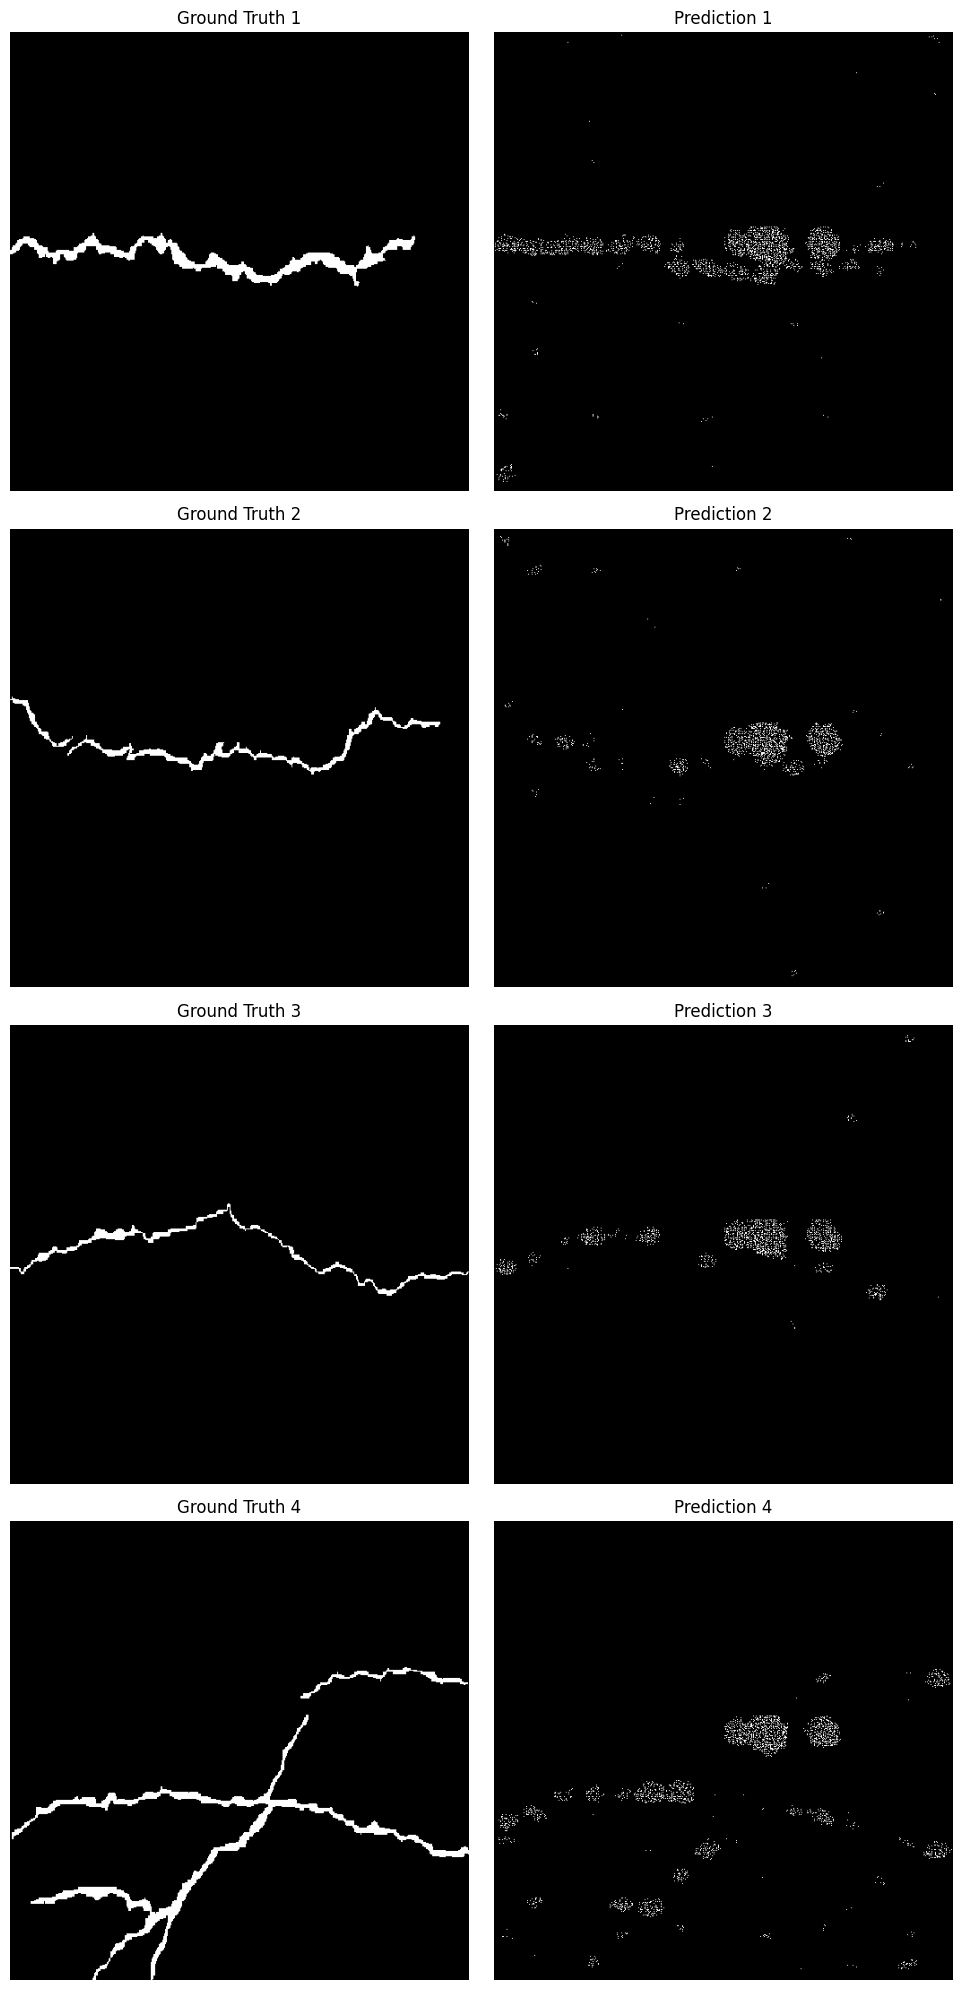

tensor(255., device='cuda:0') tensor(0., device='cuda:0')


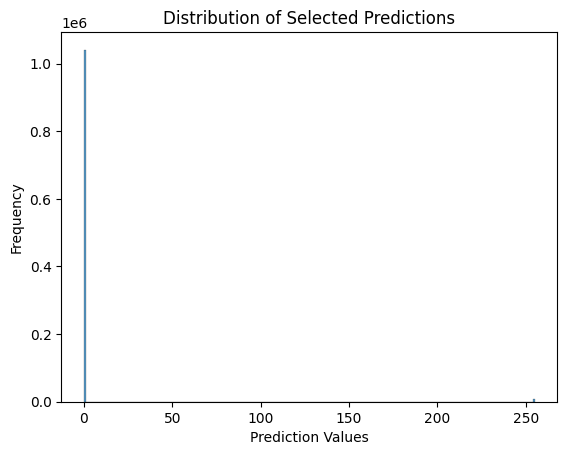

100%|██████████| 1/1 [00:02<00:00,  2.99s/it]

Accuracy in batch 0 during validation is: 0.9704


In [79]:
inference(val_loader, config)